# Test the StarNet model

This notebook takes you through the steps of how to test a trained model on given test data sets.
Requirements:
* python packages: `numpy h5py keras matplotlib seaborn sklearn`
* data files:
    - test_data.h5
    - mean_and_std.npy
    - starnet_cnn.h5

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import h5py
import time
from matplotlib import gridspec

datadir = "C:/Users/Peter/Documents/Astrophysics_Project/files/"

**Obtain data for normalizing labels and define function to denormalize labels****

In [10]:
mean_and_std = np.load(datadir + 'mean_and_std.npy')
mean_labels = mean_and_std[0]
std_labels = mean_and_std[1]
num_labels = mean_and_std.shape[1]

def denormalize(lb_norm):
    return ((lb_norm*std_labels) + mean_labels)

**Define functions to obtain test data**

In [11]:
def get_data(filename):
    f = h5py.File(datadir + filename, 'r')
    spectra_array = f['spectrum']
    ap_ids = f['Ap_ID'][:]
    labels_array = np.column_stack((f['TEFF'][:],f['LOGG'][:],f['FE_H'][:]))
    snr_array = f['combined_snr'][:]  
    return  (ap_ids, snr_array, spectra_array, labels_array)

**Load test data and model**

In [12]:
test_ap_ids, test_snr, test_spectra, test_labels = get_data('test_data.h5')
print('Test set contains '  + str(len(test_spectra))+' stars')
model = keras.models.load_model(datadir + 'starnet_cnn.h5')

Test set contains 21533 stars


** Define a function that predicts on a test set by using batches **

This allows the user to use and hdf5 matrix as the input rather than loading the entire dataset in to a numpy array

In [13]:
def batch_predictions(model, spectra, batch_size, denormalize):
    
    predictions = np.zeros((len(spectra),3))
    num_batches = int(len(spectra)/batch_size)
    for i in range(num_batches):
        inputs = spectra[i*batch_size:(i+1)*batch_size]
        # Mask any nan values
        indices_nan = np.where(np.isnan(inputs))
        inputs[indices_nan]=0.
        predictions[i*batch_size:(i+1)*batch_size] = denormalize(model.predict(inputs))
    num_remainder = int(len(spectra)%batch_size)
    if num_remainder>0:
        inputs = spectra[-num_remainder:]
        indices_nan = np.where(np.isnan(inputs))
        inputs[indices_nan]=0.
        predictions[-num_remainder:] = denormalize(model.predict(inputs))
    return predictions

** Predict on test set**

In [14]:
time1 = time.time()
test_predictions = batch_predictions(model, test_spectra, 500, denormalize)
print("{0:.2f}".format(time.time()-time1)+' seconds to make '+str(len(test_spectra))+' predictions')

61.14 seconds to make 21533 predictions


** Show residuals on test set label predictions**

In [15]:
# Some plotting variables for asthetics
%matplotlib inline
# Label names
label_names = ['$T_{\mathrm{eff}}$', '$\log(g)$', '$[Fe/H]$']

# Pipeline names
x_lab = 'ASPCAP'
y_lab = 'StarNet'

plt.rcParams['axes.facecolor']='white'
sns.set_style("ticks")
plt.rcParams['axes.grid']=True
plt.rcParams['grid.color']='gray'
plt.rcParams['grid.alpha']='0.4'

# -PS #plt.rc('text', usetex=True)
plt.rc('font', family='serif')

c:\users\peter\appdata\local\programs\python\python36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
c:\users\peter\appdata\local\programs\python\python36\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


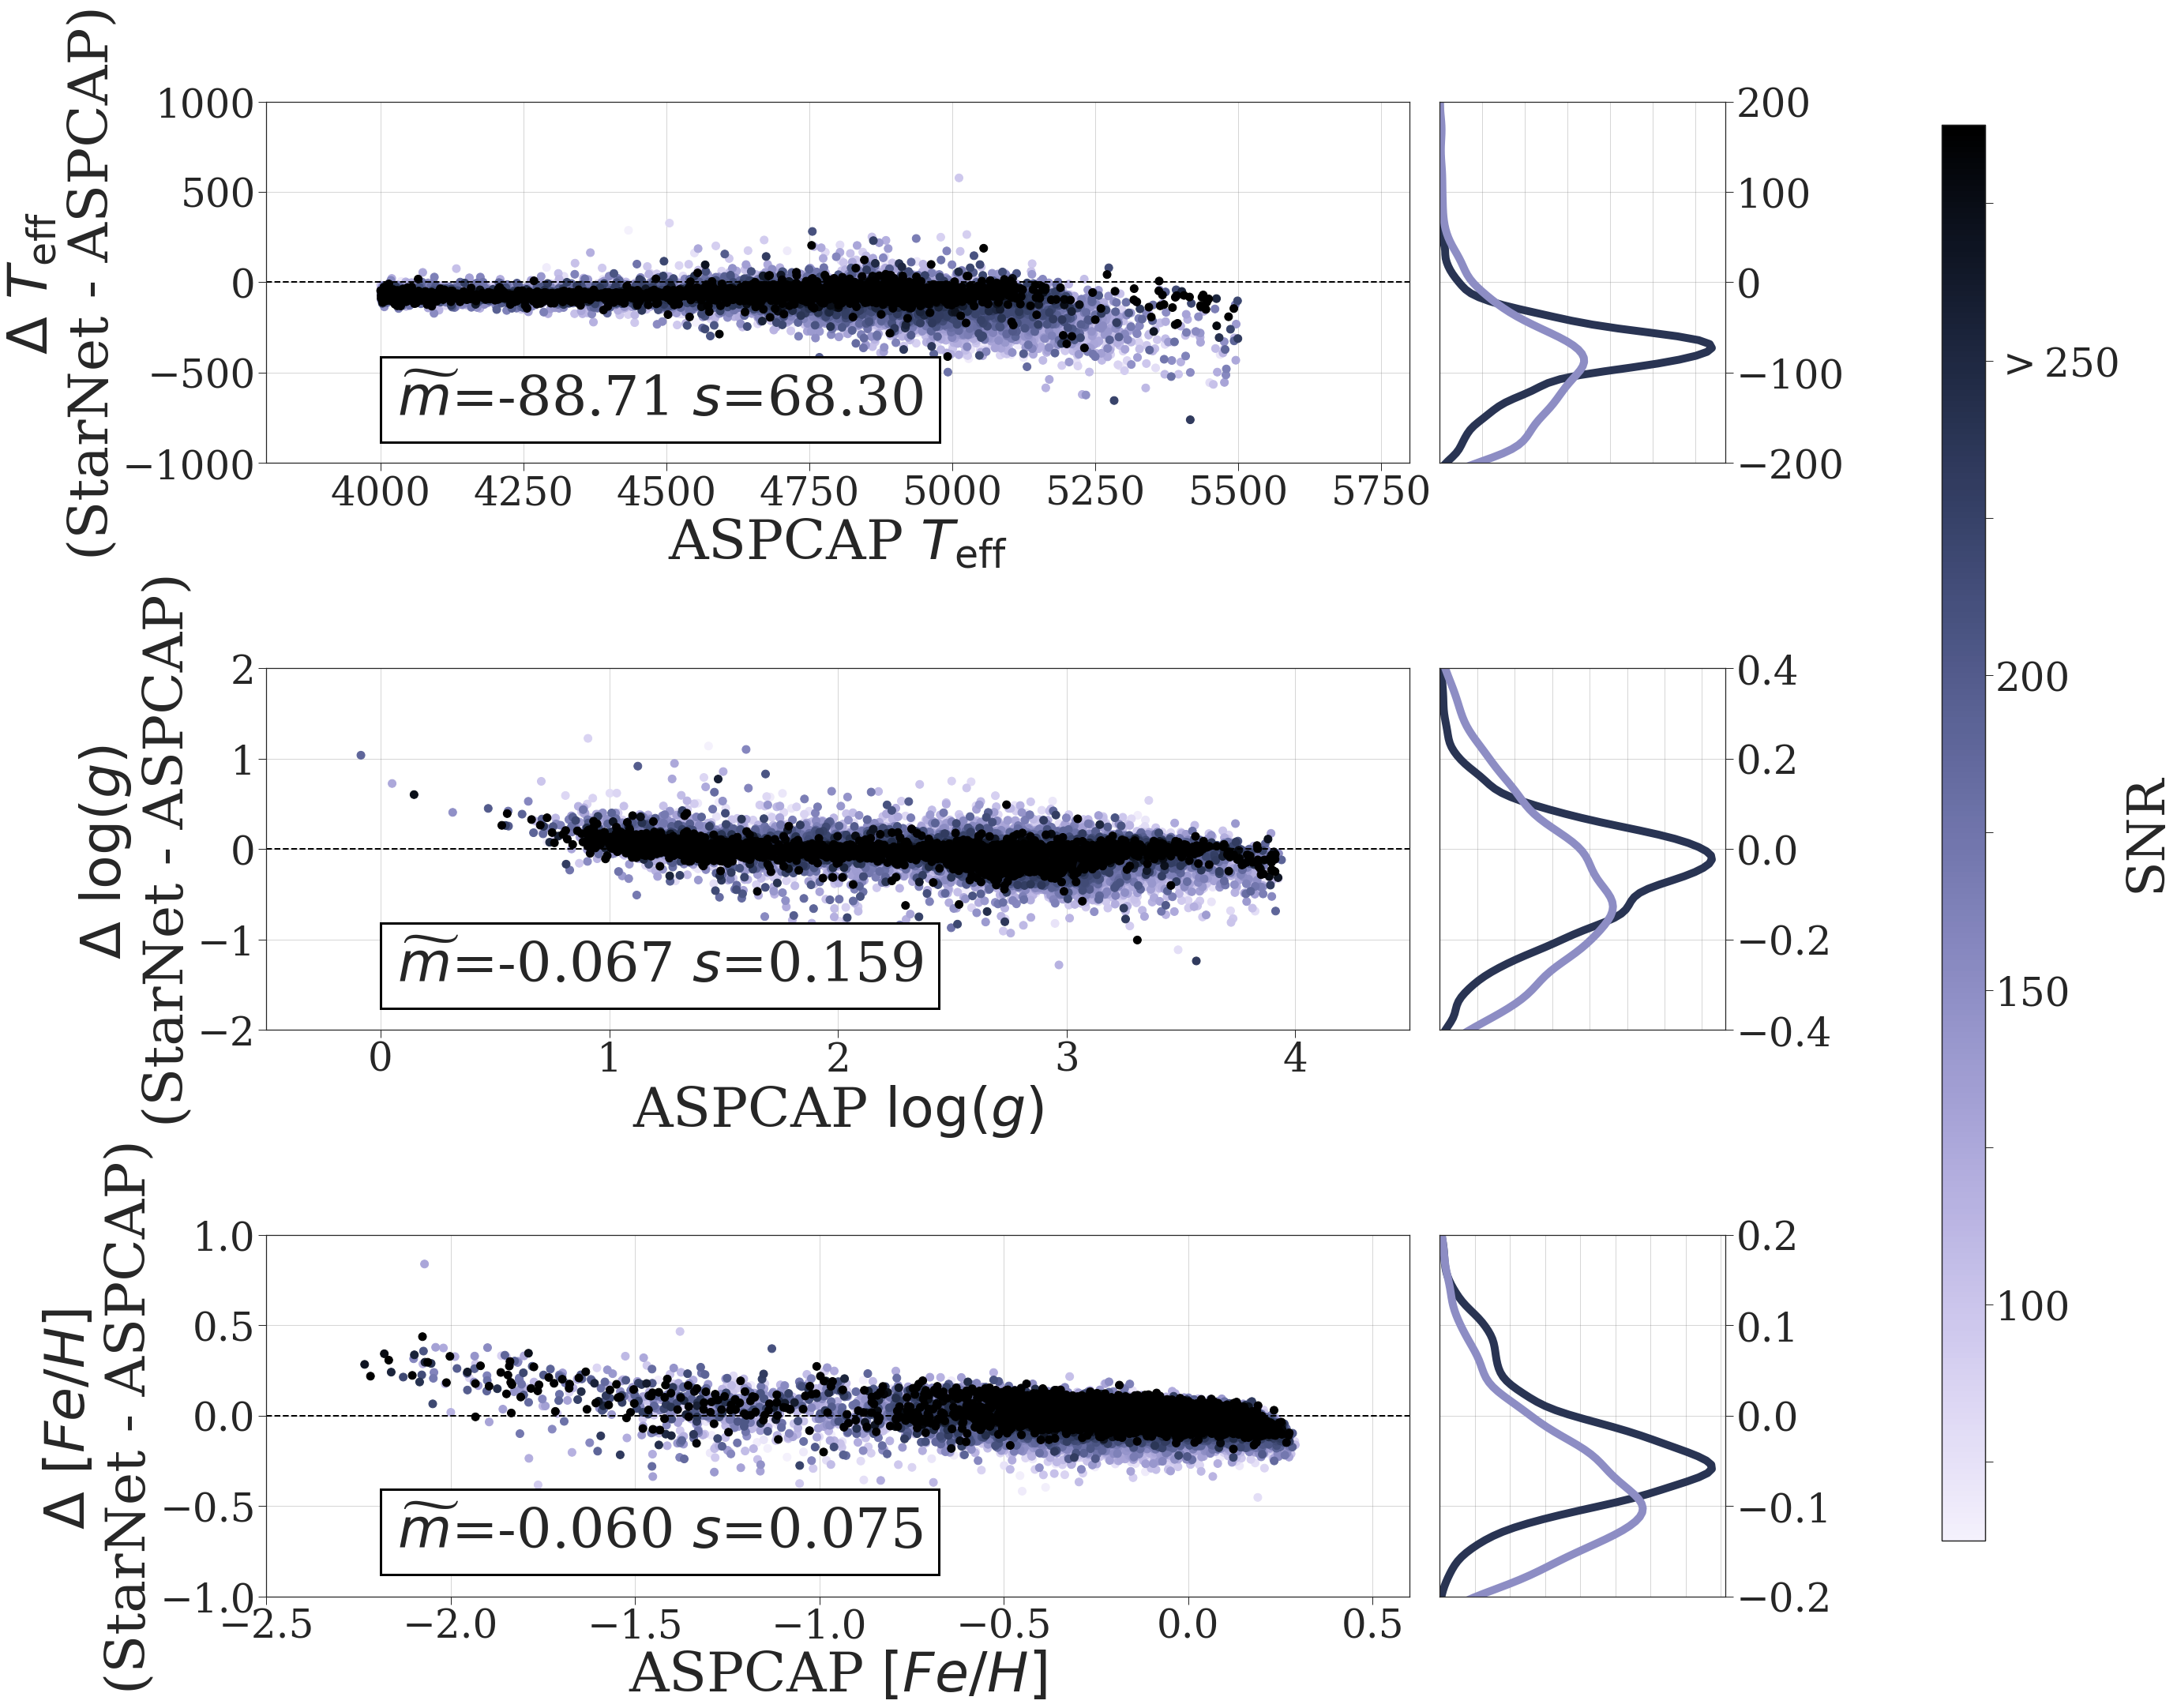

In [16]:
all_targets = test_labels
all_pred = test_predictions
z = test_snr
z[z>250]=250

resid = all_pred - all_targets

# Overplot high S/N
order = (z).reshape(z.shape[0],).argsort()
all_targets = all_targets[order]
resid = resid[order]
z = z[order,0]

bias = np.median(resid, axis=0)
scatter = np.std(resid, axis=0)

indices_a = np.where(z>=150)
indices_b = np.where(z<100)
resid_a = resid[indices_a,:]
resid_b = resid[indices_b,:]

cmap = sns.cubehelix_palette(8, start=2.8, rot=.1, dark=0, light=.95, as_cmap=True)

lims = [[(3800,5800),(-0.50,4.50),(-2.5,0.6)],[(-1000,1000),(-2.0,2.0),(-1.,1.)]]
ditribution_lims = [(-200,200),(-0.4,0.4),(-0.2,0.2)]

fig = plt.figure(figsize=(38, 30)) 
gs = gridspec.GridSpec(3, 2,  width_ratios=[4., 1])


for i in range(num_labels):

    ax0 = plt.subplot(gs[i,0])
    points = ax0.scatter(all_targets[:,i], resid[:,i], c=z, s=100, cmap=cmap)
    
    ax0.set_xlabel(x_lab + ' ' + label_names[i], fontsize=70)

    
    ax0.set_ylabel(r'$\Delta$ %s ' % (label_names[i]) +
                       '\n' + r'(%s - %s)' % (y_lab, x_lab), fontsize=70)
    
    ax0.tick_params(labelsize=50, width=1, length=10)
    ax0.set_xlim(lims[0][i])
    ax0.set_ylim(lims[1][i])
    ax0.plot([lims[0][i][0],lims[0][i][1]], [0,0], 'k--', lw=2)
 
    xmin, xmax = ditribution_lims[i]
    
    y_a = resid_a[0,:,i][(resid_a[0,:,i]>=xmin)&(resid_a[0,:,i]<=xmax)]
    y_b = resid_b[0,:,i][(resid_b[0,:,i]>=xmin)&(resid_b[0,:,i]<=xmax)]
    
    ax1 = plt.subplot(gs[i,1])
    a = sns.distplot(y_a, vertical=True,hist=False, rug=False, ax=ax1,kde_kws={"color": cmap(200), "lw": 10})
    b = sns.distplot(y_b,vertical=True,hist=False, rug=False, ax=ax1,kde_kws={"color": cmap(100), "lw": 10})
    
    a.set_ylim(ditribution_lims[i])
    b.set_ylim(ditribution_lims[i])
    
    ax1.tick_params(
    axis='x',          
    which='both',     
    bottom='off',      
    top='off',         
    labelbottom='off',width=1,length=10)
    
    ax1.tick_params(
    axis='y',          
    which='both',   
    left='off',     
    right='on',        
    labelleft='off',
    labelright='on',
    labelsize=50,width=1,length=10)
    
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=3)

    
    if i==0:
        plt.figtext(0.185, (1-((i*0.332)+0.24)),
                    '$\widetilde{m}$='+'{0:.2f}'.format(bias[i])+' $s$='+'{0:.2f}'.format(scatter[i]),
                    size=70, bbox=bbox_props)
    else:
        plt.figtext(0.185, (1-((i*0.332)+0.24)),
                    '$\widetilde{m}$='+'{0:.3f}'.format(bias[i])+' $s$='+'{0:.3f}'.format(scatter[i]),
                    size=70, bbox=bbox_props)

cbar_ax = fig.add_axes([0.9, 0.1, 0.02, 0.83])
fig.colorbar(points,cax=cbar_ax)
cbar = fig.colorbar(points, cax=cbar_ax, extend='neither', spacing='proportional', orientation='vertical', format="%.0f")
cbar.set_label('SNR', size=65)
cbar.ax.tick_params(labelsize=50,width=1,length=10) 

cbar_ax.set_yticklabels(['','100','','150','','200','','$>$250'])

plt.tight_layout()
fig.subplots_adjust(right=0.8)
plt.show()